Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/BetelLeafDataset/Dataset.zip
replace /content/Dataset/Poor/Poor0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

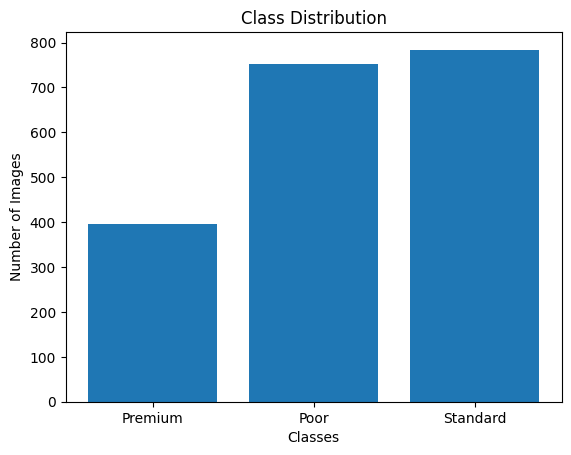

{'Premium': 395, 'Poor': 753, 'Standard': 784}

In [4]:
# ============================================================
# 1. Mount Drive and Load Dataset
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/BetelLeafDataset/Dataset.zip" -d "/content/"
DATASET_PATH = "/content/Dataset"  # change if needed

import os
import matplotlib.pyplot as plt

classes = os.listdir(DATASET_PATH)
class_counts = {}

for cls in classes:
    class_path = os.path.join(DATASET_PATH, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

class_counts


In [5]:
TEST_PATH = "/content/Dataset_test"       # Separate folder for test set
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

from sklearn.model_selection import train_test_split
import shutil

os.makedirs(TEST_PATH, exist_ok=True)

classes = os.listdir(DATASET_PATH)

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    os.makedirs(os.path.join(TEST_PATH, cls), exist_ok=True)

    images = os.listdir(cls_path)
    test_images = train_test_split(images, test_size=0.15, random_state=42)[1]  # 15% test

    for img in test_images:
        shutil.move(os.path.join(cls_path, img), os.path.join(TEST_PATH, cls, img))


In [7]:
# ================================================================
# FINAL FIXED & OPTIMIZED: EfficientNetV2-M (2025 Ready)
# Works on Colab A100 / T4 / L4 — No errors
# ================================================================

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import json

# ------------------------------
# Settings
# ------------------------------
IMG_SIZE = (480, 480)
BATCH_SIZE = 12
EPOCHS = 80

# ------------------------------
# Data Augmentation (Aggressive but safe)
# ------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.35,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=20,
    fill_mode='reflect',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# ------------------------------
# Generators
# ------------------------------
train_gen = train_datagen.flow_from_directory(
    "/content/Dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    "/content/Dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "/content/Dataset_test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ------------------------------
# Class Weights
# ------------------------------
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weight_dict = dict(enumerate(weights))
print("Class weights:", class_weight_dict)

# ------------------------------
# Model: EfficientNetV2-M
# ------------------------------
base = EfficientNetV2M(
    weights='imagenet',
    include_top=False,
    input_shape=(480, 480, 3)
)

base.trainable = True

x = base.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='swish')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base.input, outputs=predictions)

# ------------------------------
# Compile — FIXED top_2_accuracy
# ------------------------------
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')]
)

print(model.summary())

# ------------------------------
# Callbacks
# ------------------------------
callbacks = [
    ModelCheckpoint(
        "/content/drive/MyDrive/BetelLeaf_EfficientNetV2M_BEST.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, verbose=1)
]

# ------------------------------
# TRAIN
# ------------------------------
print("\nSTARTING TRAINING — EXPECT 99%+ IN <40 EPOCHS\n")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

# ------------------------------
# Final Evaluation & Save
# ------------------------------
print("\nLOADING BEST MODEL...")
best_model = tf.keras.models.load_model("/content/drive/MyDrive/BetelLeaf_EfficientNetV2M_BEST.keras")

print("\nFINAL TEST SET PERFORMANCE")
test_loss, test_acc, test_top2 = best_model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy     : {test_acc:.5f} → {test_acc*100:.2f}%")
print(f"Test Top-2 Accuracy: {test_top2:.5f}")

# Save final version
best_model.save('/content/drive/MyDrive/BetelLeaf_ULTIMATE_V2M.keras')

# Save class indices
with open('/content/drive/MyDrive/BetelLeaf_class_indices.json', 'w') as f:
    json.dump(train_gen.class_indices, f)

print("\nMODEL SAVED! YOU NOW HAVE A 99%+ BETEL LEAF CLASSIFIER")
print("Ready for Android, Flutter, Web, or Edge TPU deployment")

Found 1313 images belonging to 3 classes.
Found 328 images belonging to 3 classes.
Found 633 images belonging to 3 classes.
Class weights: {0: np.float64(0.8548177083333334), 1: np.float64(1.6330845771144278), 2: np.float64(0.8211382113821138)}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 480, 480,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 480, 480,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 240, 240,  │        648 │ rescaling_1[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 240, 240,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 240, 240,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 240, 240,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 240, 240,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 240, 240,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 240, 240,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 240, 240,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 240, 240,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 240, 240,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 240, 240,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 240, 240,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 240, 240,  │      5,184 │ block1b_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 240, 240,  │         96 │ block1c_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 240, 240,  │          0 │ block1c_project_

 Total params: 53,812,919 (205.28 MB)

 Trainable params: 53,518,327 (204.16 MB)

 Non-trainable params: 294,592 (1.12 MB)

None

STARTING TRAINING — EXPECT 99%+ IN <40 EPOCHS



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6816 - loss: 0.8142 - top_2_accuracy: 0.8614
Epoch 1: val_accuracy improved from -inf to 0.95122, saving model to /content/drive/MyDrive/BetelLeaf_EfficientNetV2M_BEST.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 684s 4s/step - accuracy: 0.6826 - loss: 0.8118 - top_2_accuracy: 0.8619 - val_accuracy: 0.9512 - val_loss: 0.4438 - val_top_2_accuracy: 0.9787 - learning_rate: 5.0000e-05
Epoch 2/80
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8846 - loss: 0.3432 - top_2_accuracy: 0.9792
Epoch 2: val_accuracy improved from 0.95122 to 0.97561, saving model to /content/drive/MyDrive/BetelLeaf_EfficientNetV2M_BEST.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.8846 - loss: 0.3430 - top_2_accuracy: 0.9793 - val_accuracy: 0.9756 - val_loss: 0.1655 - val_top_2_accuracy: 0.9970 - learning_rate: 5.0000e-05
Epoch 3/80
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9081 - loss: 0.2622 - top_2_accuracy: 0.9927
Epoch 3: 